# Experiment on feature aggregation with RNN algorithms.
* This is an experiment to see whether aggregate data points on longer time span than just one minute can improve performance and stability on RNN, especially in Fscore, considering RNN algorithms have utilized time information. 
* It is based on the thinking: An anomaly should and can only be determined by the features acrossing a rather large time span. The features extracted from the messages within only one minute are not enough to determine if there is an anomaly in this minute of time.   
* In this experiment, Aggregation of some time spans from 1 to 60 will be tested and the according mesurements (accuracy and fscore) will be compared. 

#### The base line has the following settings:
1. using aggregated data( max, avg, sum )
2. No slide window
3. Use StandardScaler

#### The evaluation matrix includs the following metrics:
1. Accuracy
2. F1-score
3. Precision
4. Recall

### Define the algrothim - RNN

In [11]:

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F


# Set the seed for generating random numbers on all GPUs.
torch.manual_seed(1) 
torch.cuda.manual_seed_all(1)

class RNN(nn.Module):
    def __init__(self, input_lstm=1, hidden_size=50, num_classes=1, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM module
        self.lstm = nn.LSTM(input_lstm, hidden_size, num_layers, batch_first=False, dropout=0)

        # Define ReLU layer
        self.relu = nn.ReLU()

        # Define the Dropout layer with 0.5 dropout rate
        self.keke_drop = nn.Dropout(p=0.5)

        # Define a fully-connected layer fc4 with 32 inputs and 2 outputs
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):


        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size).cuda())
            c0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size))
            c0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size))

        x, _ = self.lstm(x, (h0, c0))  # LSTM network, c is the state

        x = self.relu(x)               # ReLU()

        x = self.fc4(x)                # fully-connected layer
        return x

print("============================ LSTM ============================\n")
def train_test(train_x, train_y, test_x):
    # Set parameters which are referred from src/RNN_Running_Code/RNN_Run/tmp/lstm_2layer.py
    num_feature = 37
    batch_size = SEQUENCE_LENGTH 
    num_epochs = 30   # number of the epochs
    learning_rate = 0.001    # learning rate for optimization
    hidden_size = 32  # hidden size for fc4
    num_layers = 1    # number of layers for LSTM algorithm
    num_classes = 2   # number of the class
    
    sequence_length = batch_size
    input_lstm = num_feature

    test_len = test_x.shape[0]  # test data length;

    print ("batch size : " , batch_size);
    print ("test_len : " , test_len);
    print ("hidden_size : " , hidden_size);

    rnn = RNN(input_lstm, hidden_size, num_classes, num_layers)
    rnn.train()

    if torch.cuda.is_available():
        rnn.cuda()
    else:
        rnn.cpu()

    # Select criterion for loss
    criterion = nn.CrossEntropyLoss()

    # Select an optimizer
    optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate)           # or Adam

    ### Train the model ###

    # Change data format for PyTorch
    train_data_x, train_label_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
    train_data, train_label = train_data_x.type(torch.FloatTensor), train_label_y.type(torch.LongTensor)
    torch_dataset_train = Data.TensorDataset(train_data, train_label)
    train_loader = Data.DataLoader(dataset=torch_dataset_train, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        print("Epoch : ", epoch)
        for i, (train, labels) in enumerate(train_loader):                        # load the data
            # print("train type:" , type(train))
            if train.size(0) != batch_size: 
                raise ValueError("Error: Dataset size is not divisible by batch size!")             
            if torch.cuda.is_available():
                x = Variable(train.view(sequence_length, -1, input_lstm)).cuda()  # reshape x to (time_step, batch, input_size)
                y = Variable(labels).cuda()                                       # batch labels
            else:
                x = Variable(train.view(sequence_length, -1, input_lstm))
                y = Variable(labels)
            # Forward + Backward + Optimize
            outputs = rnn(x)                                                      # RNN output
            outputs = outputs.view(-1, 2)
            loss = criterion(outputs, y)                                          # cross entropy loss
            optimizer.zero_grad()                                                 # clear gradients for this training step
            loss.backward()                                                       # back-propagation: compute gradients
            optimizer.step()                                                      # apply gradients



    ### Test the model using evaluation mode ###
    
    # Change data format for PyTorch
    test_data_x = torch.from_numpy(test_x)
    test_data = test_data_x.type(torch.FloatTensor)
    torch_dataset_test = Data.TensorDataset(test_data, torch.zeros(test_data.size(0)))
    test_loader = Data.DataLoader(dataset=torch_dataset_test, batch_size=batch_size, shuffle=False)

    rnn.eval()  # evaluation mode for testing
    yo = []
    for test, _ in test_loader:
        if test.size(0) != batch_size:
            raise ValueError("Error: Dataset size is not divisible by batch size!")             
        if torch.cuda.is_available():
            p = Variable(test.view(sequence_length, -1, input_lstm)).cuda()
        else:
            p = Variable(test.view(sequence_length, -1, input_lstm))
        outputs2 = rnn(p)
        outputs2 = outputs2.view(-1, 2)
        outputs2 = F.softmax(outputs2, dim=1)

        _, predicted = torch.max(outputs2.data, 1)
        if torch.cuda.is_available():
            predicted = predicted.cpu()
        predicted_np = predicted.numpy()
        yo.append(predicted_np)                # predicted labels, yo shape is (1, 72, 100, 1)

    yo = np.array([yo]).reshape(test_len, -1)  
    print("yo shape : ", yo.shape)
    return yo


============================ LSTM ============================



### Integrated run

Data combo: {'train': ['Code_Red_I', 'Nimda'], 'test': 'Slammer'}
Raw training datasets shape:  [(7200, 42), (8609, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6331 869
Data combo: {'train': ['Nimda', 'Slammer'], 'test': 'Code_Red_I'}
Raw training datasets shape:  [(8609, 42), (7200, 42)]
Raw training labels of regular and anomaly:  [(7308, 1301), (6331, 869)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6600 600
Data combo: {'train': ['Code_Red_I', 'Slammer'], 'test': 'Nimda'}
Raw training datasets shape:  [(7200, 42), (7200, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (6331, 869)]
Raw test dataset shape:  (8609, 42)
Raw test labels of regular and anomaly:  7308 1301
------------------------------ Time span: 1 ------------------------------
Data combo: {'train': ['Code_Red_I', 'Nimda'], 'test': 'Slammer'}
Accuracy: 91.93%, F

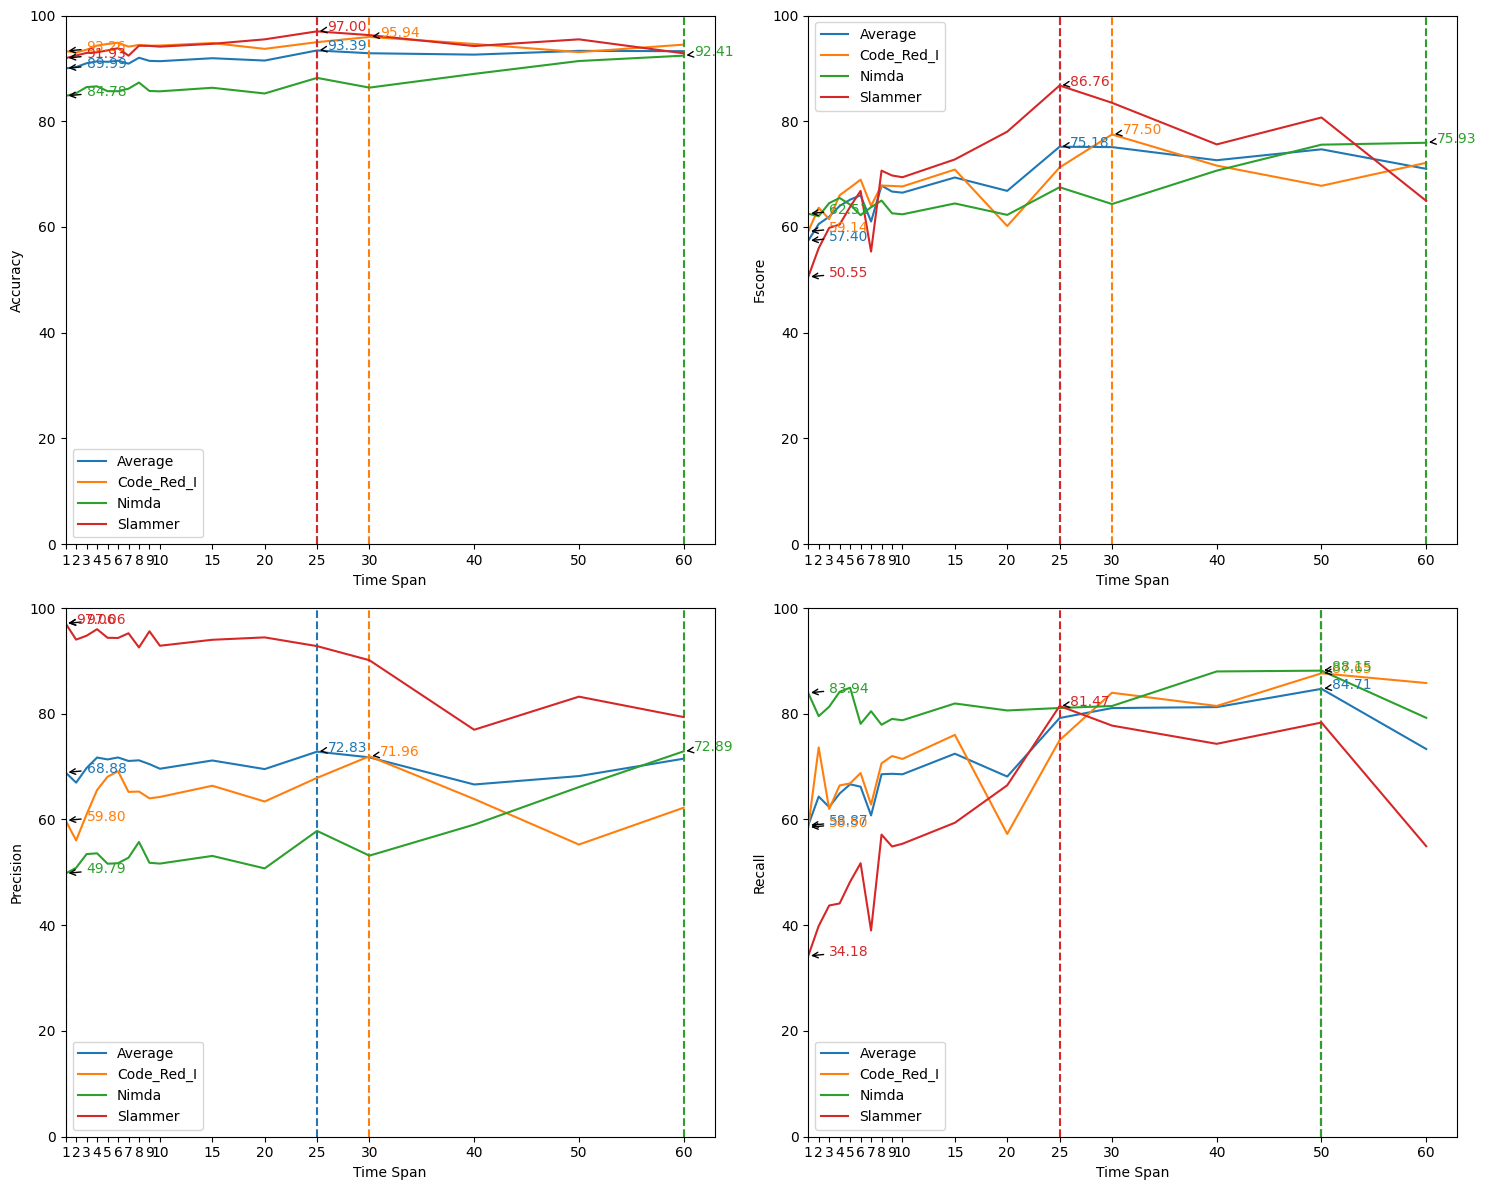

In [12]:
from src.xpr_test import *

time_span_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60]
data_combos = [{"train": ["Code_Red_I", "Nimda"], "test": "Slammer"},
                {"train": ["Nimda", "Slammer"], "test": "Code_Red_I"},
                {"train": ["Code_Red_I", "Slammer"], "test": "Nimda"},
                ]

# Set the sequence length for RNN algorithm.
SEQUENCE_LENGTH = 5

results = aggregation_test(train_test, time_span_list, data_combos, normal_label=0, dataModulo=SEQUENCE_LENGTH, sliding_window=True)
plot_aggregation_test_results(results, time_span_list)